# Predict Sex

This notebook goes through a simple binary classification example, explaining general library functionality along the way.
Within this notebook we make use of data downloaded from Release 2.0.1 of the the ABCD Study (https://abcdstudy.org/).
This dataset is openly available to researchers (after signing a data use agreement) and is particularly well suited
towards performing neuroimaging based ML given the large sample size of the study.

Within this notebook we will be performing binary classification predicting sex assigned at birth from tabular ROI structural MRI data.

In [1]:
import BPt as bp
import pandas as pd
import os

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
def load_from_rds(names, eventname='baseline_year_1_arm_1'):
    
    data = pd.read_csv('data/nda_rds_201.csv',
                       usecols=['src_subject_id', 'eventname'] + names,
                       na_values=['777', 999, '999', 777])
    
    data = data.loc[data[data['eventname'] == eventname].index]
    data = data.set_index('src_subject_id')
    data = data.drop('eventname', axis=1)
    
    # Obsificate subject ID for public example
    data.index = list(range(len(data)))
    
    # Return as pandas DataFrame cast to BPt Dataset
    return bp.Dataset(data)

In [3]:
# This way we can look at all column avaliable
all_cols = list(pd.read_csv('data/nda_rds_201.csv', nrows=0))

We can search through all column to find which columns we actually want to load. We will start with the brain imaging features.

In [4]:
feat_keys = {'thick': 'smri_thick_cort.destrieux_g.',
             'sulc': 'smri_sulc_cort.destrieux_g.',
             'area': 'smri_area_cort.destrieux_g.',
             'subcort': 'smri_vol_subcort.aseg_'}

feat_cols = {key: [c for c in all_cols if feat_keys[key] in c] for key in feat_keys}
all_cols = sum(feat_cols.values(), [])

# For example
feat_cols['thick'][:10]

['smri_thick_cort.destrieux_g.and.s.frontomargin.lh',
 'smri_thick_cort.destrieux_g.and.s.occipital.inf.lh',
 'smri_thick_cort.destrieux_g.and.s.paracentral.lh',
 'smri_thick_cort.destrieux_g.and.s.subcentral.lh',
 'smri_thick_cort.destrieux_g.and.s.transv.frontopol.lh',
 'smri_thick_cort.destrieux_g.and.s.cingul.ant.lh',
 'smri_thick_cort.destrieux_g.and.s.cingul.mid.ant.lh',
 'smri_thick_cort.destrieux_g.and.s.cingul.mid.post.lh',
 'smri_thick_cort.destrieux_g.cingul.post.dorsal.lh',
 'smri_thick_cort.destrieux_g.cingul.post.ventral.lh']

We also need our target variable, in this case sex.

In [5]:
target = 'sex'

In [6]:
data = load_from_rds(all_cols + [target])
data.verbose = 1
data

,sex,smri_area_cort.destrieux_g.and.s.cingul.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.rh,smri_area_cort.destrieux_g.and.s.frontomargin.lh,smri_area_cort.destrieux_g.and.s.frontomargin.rh,smri_area_cort.destrieux_g.and.s.occipital.inf.lh,...,smri_vol_subcort.aseg_subcorticalgrayvolume,smri_vol_subcort.aseg_supratentorialvolume,smri_vol_subcort.aseg_thalamus.proper.lh,smri_vol_subcort.aseg_thalamus.proper.rh,smri_vol_subcort.aseg_ventraldc.lh,smri_vol_subcort.aseg_ventraldc.rh,smri_vol_subcort.aseg_wholebrain,smri_vol_subcort.aseg_wm.hypointensities,smri_vol_subcort.aseg_wm.hypointensities.lh,smri_vol_subcort.aseg_wm.hypointensities.rh
0,F,1540.0,1921.0,1237.0,1211.0,939.0,1022.0,872.0,596.0,820.0,...,54112.0,9.738411e+05,6980.4,6806.6,3448.1,3372.7,1.099494e+06,2201.9,0.0,0.0
1,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M,2108.0,2583.0,1289.0,1295.0,1066.0,1328.0,907.0,843.0,1571.0,...,71188.0,1.290405e+06,9091.3,8105.3,5058.5,5261.6,1.444690e+06,1254.8,0.0,0.0
3,M,2196.0,2266.0,1012.0,1459.0,1326.0,1398.0,944.0,924.0,1209.0,...,61985.0,1.283405e+06,7470.7,7278.4,3924.8,3983.6,1.421171e+06,950.9,0.0,0.0
4,M,1732.0,1936.0,1024.0,916.0,900.0,1002.0,863.0,730.0,969.0,...,61855.0,1.072113e+06,8152.9,7436.8,4085.2,4129.3,1.186497e+06,789.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,M,1583.0,1821.0,730.0,1040.0,709.0,872.0,938.0,745.0,789.0,...,59550.0,1.001272e+06,7993.5,7239.5,3899.4,4024.6,1.139532e+06,651.7,0.0,0.0
11871,F,1603.0,1841.0,899.0,1091.0,990.0,995.0,809.0,666.0,1155.0,...,61090.0,9.897016e+05,7113.5,6835.3,4029.6,3826.0,1.134203e+06,2304.8,0.0,0.0
11872,F,1862.0,2245.0,1406.0,1502.0,882.0,1279.0,1105.0,1015.0,1256.0,...,64413.0,1.172208e+06,8123.0,7947.6,3893.0,4428.5,1.301402e+06,1654.0,0.0,0.0
11873,F,1803.0,1888.0,967.0,1101.0,866.0,1128.0,1040.0,642.0,939.0,...,55505.0,1.040864e+06,6923.8,6459.8,3502.5,3674.0,1.150473e+06,1209.5,0.0,0.0


Next we need to tell the dataset a few things about sex, namely that it is a binary variable, and that it is our target variable.

In [7]:
data.to_binary('sex', inplace=True)
data.set_target('sex', inplace=True)
data['target']

,sex
0,0
1,0
2,1
3,1
4,1
...,...
11870,1
11871,0
11872,0
11873,0


Let's look at some NaN info

In [8]:
data.nan_info()

Loaded NaN Info:
There are: 94062 total missing values
223 columns found with 341 missing values (column name overlap: ['cort.', 'smri_'])
8 columns found with 342 missing values (column name overlap: ['cort.', 'smri_'])
5 columns found with 343 missing values (column name overlap: ['cort.', 'smri_', 'area'])
3 columns found with 384 missing values (column name overlap: ['smri_area_cort.destrieux_g.'])
3 columns found with 346 missing values (column name overlap: ['cort.', 'smri_'])
3 columns found with 453 missing values (column name overlap: ['smri_vol_subcort.aseg_', 'le'])
2 columns found with 387 missing values (column name overlap: ['smri_area_cort.destrieux_g.and.s.', 'in'])
2 columns found with 379 missing values (column name overlap: ['smri_area_cort.destrieux_g.', '.lh', 'an', '.s'])
2 columns found with 344 missing values (column name overlap: ['smri_area_cort.destrieux_g.'])
2 columns found with 352 missing values (column name overlap: ['smri_area_cort.destrieux_g.', 'temp.

What happens now if we drop any subjects with more than 1% of their loaded columns with NaN values

In [9]:
data = data.drop_subjects_by_nan(threshold=.01)
data.nan_info()

Setting NaN threshold to: 2.73
Dropped 453 Rows
Loaded NaN Info:
There are: 961 total missing values
8 columns found with 1 missing values (column name overlap: ['cort.', 'smri_'])
5 columns found with 2 missing values (column name overlap: ['cort.', 'smri_', 'area'])
4 columns found with 5 missing values (column name overlap: [])
2 columns found with 49 missing values (column name overlap: ['smri_area_cort.destrieux_g.', 'ra', '.t', 'd.'])
2 columns found with 46 missing values (column name overlap: ['smri_area_cort.destrieux_g.and.s.', 'in'])
2 columns found with 3 missing values (column name overlap: ['smri_area_cort.destrieux_g.'])
2 columns found with 43 missing values (column name overlap: ['smri_area_cort.destrieux_g.and.s.', '.rh', 'al'])
2 columns found with 11 missing values (column name overlap: ['smri_area_cort.destrieux_g.', 'temp.', '.lat'])



That greatly reduces the number of remaining missing values we have. Next, let's consider outlier filtering as...

In [10]:
data.skew().sort_values()

smri_thick_cort.destrieux_g.front.middle.rh          -1.475994
smri_thick_cort.destrieux_g.temporal.middle.lh       -1.306818
smri_thick_cort.destrieux_g.precentral.rh            -1.266633
smri_thick_cort.destrieux_g.pariet.inf.angular.rh    -1.260234
smri_thick_cort.destrieux_g.temporal.middle.rh       -1.222911
                                                       ...    
smri_vol_subcort.aseg_lateral.ventricle.lh            4.053670
smri_vol_subcort.aseg_lateral.ventricle.rh            4.403390
smri_area_cort.destrieux_g.cingul.post.ventral.lh     4.897899
smri_area_cort.destrieux_g.cingul.post.ventral.rh     4.898569
smri_vol_subcort.aseg_wm.hypointensities             16.250108
Length: 272, dtype: float64

In [11]:
# We don't even care about this
data = data.drop_cols(exclusions='aseg_wm.hypointensities')

Dropped 3 Columns


In [12]:
data = data.filter_outliers_by_std(n_std=10)

Dropped 61 Rows


sex: 11356 rows (5 NaN)


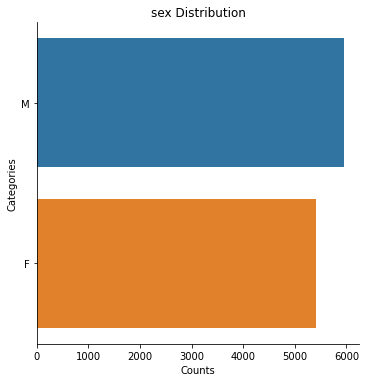

In [13]:
data.plot('target')

Note we have some missing data in the target variable, we can drop these.

In [14]:
data = data.drop_nan_subjects('target')

Dropped 5 Rows


Let's split our data in a train test split.

In [15]:
train_data, test_data = data.test_split(size=.2, random_state=2)
train_data

Performing test split on: 11356 subjects.
random_state: 2
Test split size: 0.2

Performed train/test split
Train size: 9084
Test size:  2272


,smri_area_cort.destrieux_g.and.s.cingul.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.ant.rh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.lh,smri_area_cort.destrieux_g.and.s.cingul.mid.post.rh,smri_area_cort.destrieux_g.and.s.frontomargin.lh,smri_area_cort.destrieux_g.and.s.frontomargin.rh,smri_area_cort.destrieux_g.and.s.occipital.inf.lh,smri_area_cort.destrieux_g.and.s.occipital.inf.rh,...,smri_vol_subcort.aseg_pallidum.rh,smri_vol_subcort.aseg_putamen.lh,smri_vol_subcort.aseg_putamen.rh,smri_vol_subcort.aseg_subcorticalgrayvolume,smri_vol_subcort.aseg_supratentorialvolume,smri_vol_subcort.aseg_thalamus.proper.lh,smri_vol_subcort.aseg_thalamus.proper.rh,smri_vol_subcort.aseg_ventraldc.lh,smri_vol_subcort.aseg_ventraldc.rh,smri_vol_subcort.aseg_wholebrain
0,1540.0,1921.0,1237.0,1211.0,939.0,1022.0,872.0,596.0,820.0,839.0,...,1392.5,5471.6,5002.9,54112.0,9.738411e+05,6980.4,6806.6,3448.1,3372.7,1.099494e+06
2,2108.0,2583.0,1289.0,1295.0,1066.0,1328.0,907.0,843.0,1571.0,1056.0,...,2102.4,6520.7,6929.8,71188.0,1.290405e+06,9091.3,8105.3,5058.5,5261.6,1.444690e+06
4,1732.0,1936.0,1024.0,916.0,900.0,1002.0,863.0,730.0,969.0,1000.0,...,1715.1,6078.6,6013.7,61855.0,1.072113e+06,8152.9,7436.8,4085.2,4129.3,1.186497e+06
5,1346.0,1855.0,832.0,1101.0,855.0,930.0,722.0,769.0,1249.0,789.0,...,1466.2,5281.3,4990.4,52886.0,9.367869e+05,6385.2,5843.4,3557.2,3420.8,1.047860e+06
6,1537.0,1986.0,1151.0,1178.0,1182.0,1389.0,839.0,678.0,1250.0,1207.0,...,1859.0,6599.7,6317.0,65182.0,1.135326e+06,8437.8,8259.8,3734.3,4159.9,1.263524e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,1583.0,1821.0,730.0,1040.0,709.0,872.0,938.0,745.0,789.0,825.0,...,1610.9,6090.9,5444.8,59550.0,1.001272e+06,7993.5,7239.5,3899.4,4024.6,1.139532e+06
11871,1603.0,1841.0,899.0,1091.0,990.0,995.0,809.0,666.0,1155.0,844.0,...,1664.6,7042.9,6654.0,61090.0,9.897016e+05,7113.5,6835.3,4029.6,3826.0,1.134203e+06
11872,1862.0,2245.0,1406.0,1502.0,882.0,1279.0,1105.0,1015.0,1256.0,960.0,...,1856.8,6331.3,6366.1,64413.0,1.172208e+06,8123.0,7947.6,3893.0,4428.5,1.301402e+06
11873,1803.0,1888.0,967.0,1101.0,866.0,1128.0,1040.0,642.0,939.0,892.0,...,1470.9,5730.4,5469.3,55505.0,1.040864e+06,6923.8,6459.8,3502.5,3674.0,1.150473e+06


In [16]:
ps = bp.ProblemSpec(scorer=['roc_auc'],
                    n_jobs=16)
ps

ProblemSpec(n_jobs=16, scorer=['roc_auc'])

In [17]:
model_pipeline = bp.ModelPipeline(model=bp.Model('dt'))
model_pipeline.print_all()

ModelPipeline
-------------
imputers=\
Imputer(obj='default')

scalers=\
Scaler(obj='standard')

model=\
Model(obj='dt')

param_search=\
None



We can see that the their are a few default values, specifically we have a set of default imputers, one for replacing all float variables with the mean value, and one for replacing all categorical / binary variables (if any, otherwise ignored) with the median values.

Next, we have a just standard scaler, which scales all features to have mean 0, std of 1.

Then, we have our decision tree.

Lastly, we have no param_search specified.

Now that we have an initial model, we are ready to use the Evaluate function

In [18]:
results = bp.evaluate(pipeline=model_pipeline,
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)

results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.6416069711113249}
std_scores = {'roc_auc': 0.010678367090234725}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'feature_importances_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_feature_importances', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

Let's try a just linear model now (Logistic Regression, since binary), updating our model within our model_pipeline first.

In [19]:
model_pipeline.model = bp.Model('linear')

results = bp.evaluate(pipeline=model_pipeline,
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)

results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.903625961725159}
std_scores = {'roc_auc': 0.004037404292329663}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

In [20]:
results.get_fis(mean=True).sort_values()

smri_vol_subcort.aseg_caudate.rh                   -0.645759
smri_vol_subcort.aseg_thalamus.proper.lh           -0.421250
smri_thick_cort.destrieux_g.postcentral.rh         -0.404056
smri_vol_subcort.aseg_wholebrain                   -0.376275
smri_vol_subcort.aseg_cerebellum.white.matter.rh   -0.365137
                                                      ...   
smri_vol_subcort.aseg_thalamus.proper.rh            0.360649
smri_vol_subcort.aseg_putamen.rh                    0.449518
smri_vol_subcort.aseg_cerebellum.cortex.rh          0.520414
smri_vol_subcort.aseg_intracranialvolume            0.632200
smri_vol_subcort.aseg_cerebral.white.matter.rh      1.045681
Length: 269, dtype: float64

What we find here is a bit trivial. Basically just boys have bigger brains than girls ... That said, this is just an example. What if we say residualize in a nested way for intracranial volume?

In [21]:
from BPt.extensions import LinearResidualizer

resid = LinearResidualizer(to_resid_df=data[['smri_vol_subcort.aseg_intracranialvolume']])
resid_scaler = bp.Scaler(resid, scope='float')


resid_pipeline = bp.ModelPipeline(scalers=[bp.Scaler('robust'), resid_scaler],
                                  model=bp.Model('linear'))   

resid_pipeline.print_all()

ModelPipeline
-------------
imputers=\
Imputer(obj='default')

scalers=\
[Scaler(obj='robust'),
 Scaler(obj=LinearResidualizer(to_resid_df=       smri_vol_subcort.aseg_intracranialvolume
0                                  1.354788e+06
2                                  1.703982e+06
3                                  1.679526e+06
4                                  1.561216e+06
5                                  1.415059e+06
...                                         ...
11870                              1.480336e+06
11871                              1.470497e+06
11872                              1.455727e+06
11873                              1.480286e+06
11874                              1.500072e+06

[11356 rows x 1 columns]))]

model=\
Model(obj='linear')

param_search=\
None



In [22]:
results = bp.evaluate(pipeline=model_pipeline,
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)

results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.903625961725159}
std_scores = {'roc_auc': 0.004037404292329663}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

In [23]:
results.get_fis(mean=True).sort_values()

smri_vol_subcort.aseg_caudate.rh                   -0.645759
smri_vol_subcort.aseg_thalamus.proper.lh           -0.421250
smri_thick_cort.destrieux_g.postcentral.rh         -0.404056
smri_vol_subcort.aseg_wholebrain                   -0.376275
smri_vol_subcort.aseg_cerebellum.white.matter.rh   -0.365137
                                                      ...   
smri_vol_subcort.aseg_thalamus.proper.rh            0.360649
smri_vol_subcort.aseg_putamen.rh                    0.449518
smri_vol_subcort.aseg_cerebellum.cortex.rh          0.520414
smri_vol_subcort.aseg_intracranialvolume            0.632200
smri_vol_subcort.aseg_cerebral.white.matter.rh      1.045681
Length: 269, dtype: float64

Notably residualizing is far from perfect (imo garbage...), it is interesting though how the results change when we add the residualization. We can just ignore the issue for now, and explore some different pipelines (not residualizing anymore). We are going to just try some off the shelf default pipelines for simplicity.

In [24]:
from BPt.default.pipelines import pipelines

results = bp.evaluate(pipeline=pipelines['lgbm_pipe'],
                      dataset=train_data,
                      problem_spec=ps,
                      cv=5)
results

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.8863269603808108}
std_scores = {'roc_auc': 0.0027329159182744186}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'feature_importances_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_feature_importances', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

In [25]:
pipelines['lgbm_pipe']

Pipeline(steps=[Imputer(obj='mean', scope='float'),
                Imputer(obj='median', scope='category'), Scaler(obj='robust'),
                Transformer(obj='one hot encoder', scope='category'),
                Model(obj='lgbm',
                      param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy()),
                                               n_iter=60),
                      params=1)])

In [26]:
# User cv=3 for runtime reasons
results = bp.evaluate(pipeline=pipelines['stacking_pipe'],
                      dataset=train_data,
                      problem_spec=ps,
                      cv=3)
results

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'roc_auc': 0.8589750730819228}
std_scores = {'roc_auc': 0.003731209094578198}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores']

Avaliable Methods: ['get_preds_dfs', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=16, problem_type='binary',
            scorer={'roc_auc': make_scorer(roc_auc_score, needs_threshold=True)},
            subjects='all', target='sex')

In [27]:
pipelines['stacking_pipe']

Pipeline(steps=[Imputer(obj='mean', scope='float'),
                Imputer(obj='median', scope='category'), Scaler(obj='robust'),
                Transformer(obj='one hot encoder', scope='category'),
                Ensemble(base_model=Model(obj='ridge',
                                          param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy()),
                                                                   n_iter=60),
                                          params=1),
                         models=[Model(obj='elastic',
                                       param_search=ParamSearch(cv=CV(cv_strategy=CVS...
                                       param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy()),
                                                                n_iter=60),
                                       params=1),
                                 Model(obj=Pipeline(param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy()),
                                    